
# Inception V3 for flowers102


使用 Inception V3模型对 flowers102数据集分类问题，进行迁移学习。

参考： <https://github.com/Arsey/keras-transfer-learning-for-oxford102>

过一遍这个例子

问题：

1. 为什么训练集、测试集提前划分好？其实训练前就应该准备好，划分好。
2. 其实只需要划分成训练集和验证集。 但是这里按照代码的先跑一遍。
3. 以前学习，验证集是用来找最合适的模型的，防止过拟合。这里怎么进行网格搜寻？？ 



In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

## 1. 准备数据

这里是102flowers数据，包括102种花。

来源： <http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html>

准备训练集、验证集和测试集以及标签。以及batch方法

### 1.1 下载数据，观察数据格式

`102flowers.tgz` 文件，解压后是 : `image_xxxxx.jpg`格式， `xxxxx` 是图片id。

`imagelabels.mat` 文件， mat文件， 按id顺序包含分类标签（数字）。

`setid.mat`文件， 按id 分为 训练集/验证集/测试集。 有点奇怪是 测试集数据还比较多。。

In [2]:
import os
import tarfile

from urllib.request import urlretrieve
from scipy.io import loadmat


# Download the Oxford102 dataset into the current directory
data_path = '../readonly/week3'
tmp_path = '/tmp/aml/c1w3'

def ensure_path_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
ensure_path_exists(data_path)
ensure_path_exists(tmp_path)   


def download_file(url, dest=None):
    if not dest:
        dest = os.path.join(data_path, url.split('/')[-1])
    urlretrieve(url, dest)

flowers_archive_path = os.path.join(data_path, '102flowers.tgz')
if not os.path.isfile(flowers_archive_path):
    print ('Downloading images...')
    download_file('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz')
tarfile.open(flowers_archive_path).extractall(path=tmp_path)

image_labels_path = os.path.join(data_path, 'imagelabels.mat')
if not os.path.isfile(image_labels_path):
    print("Downloading image labels...")
    download_file('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat')

setid_path = os.path.join(data_path, 'setid.mat')
if not os.path.isfile(setid_path):
    print("Downloading train/test/valid splits...")
    download_file('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat')

# Read .mat file containing training, testing, and validation sets.
setid = loadmat(setid_path)

In [3]:
idx_train = setid['trnid'][0] - 1
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

print(len(idx_train))
print(len(idx_test))
print(len(idx_valid))

1020
6149
1020


In [4]:
image_labels = loadmat(image_labels_path)['labels'][0] - 1

In [5]:
len(image_labels)

8189

### 1.2 观察图片和标签

### 1.3 Data Augumentation方法

###  1.4 Batch方法

In [6]:
# get_train_datagen(rotation_range=30.,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    preprocessing_function=self.preprocess_input),



关于 `ImageDataGenerator` 和 `flow_from_directory`

1. 如果什么参数都不给（除了路径）， `flow_from_directory` 会从路径下解析所有子目录，作为类。所以默认的做法是目录下面包括所有类，作为子目录。 可以看 `flow_from_directory` 的源码， 其实是创建一个 `DirectoryIterator` 对象。解析目录及文件，用了多线程池的操作，可以学习一下。
2. seed 固定，可以观察一些图形的处理和变形
3. target_size，指定输出图形的size。（内部通过 PIL Image对象的resize方法）
4. classes，可以指定类名，这样就不用解析了。这里类名实际上就是 `0, 1, 2, ..., 101`。

对于` ImageDataGenerator`的一些形变：
1. `preprocessing_function` 需要一个函数，用于预处理图片。keras有一个bug，就是在用 `flow_from_directory`的时候， 预处理的输入x不是np.array，而是 一个PIL Image。预处理在这里没有任何作用。。** 直接改keras源代码了，囧。 **
2. 另一个奇怪的事情： imshow的时候，pixels数值最好范围在 (0, 1) 之间，为什么？看了一下文档，可以是整数，也可以是浮点。范围不一样。
3. 



/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 6149 images belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


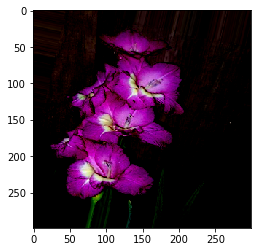

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# def preprocess_input(x):
#     pixels = x.load()
#     for i in range(x.size[0]):    # for every col:
#         for j in range(x.size[1]):    # For every row
#             pixels[i,j] = tuple(map(lambda c: (c / 255. - 0.5) * 2., pixels[i,j]))
#     return x

IMAGE_SIZE = (299, 299)

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def train_data_generator(image_size=IMAGE_SIZE, seed=None):
    idg = ImageDataGenerator(rotation_range=30., shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                             preprocessing_function=preprocess_input)

    return idg.flow_from_directory('/tmp/aml/c1w3/sorted/train', target_size=image_size, seed=seed)
    
def validation__data_generator(image_size=IMAGE_SIZE, seed=None):
    idg = ImageDataGenerator(preprocessing_function=preprocess_input)
    return idg.flow_from_directory('/tmp/aml/c1w3/sorted/valid', target_size=image_size, seed=seed)  

batch_x, batch_y = next(train_data_generator(seed=1))

plt.imshow(batch_x[0])

In [8]:
print(batch_x.shape)

(32, 299, 299, 3)


## 2. 准备模型

### 2.1 使用 inception_v3模型

tensorflow的model文件，参考这个文章： <https://www.tensorflow.org/extend/tool_developers/>

In [22]:
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adamax, SGD
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

s = reset_tf_session()

IMAGE_SHAPE = (299, 299, 3)
NUM_CLASSES = 102
NUM_FREEZE_LAYERS = -50

def create_model(freeze_layers_number=NUM_FREEZE_LAYERS):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
            
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='elu', name='fc1')(x)
    x = Dropout(0.6)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze layers
    for layer in model.layers[:freeze_layers_number]:
        layer.trainable = False
    for layer in model.layers[freeze_layers_number:]:
        layer.trainable = True
    
    # compile
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adamax(lr=0.01),
        metrics=['accuracy'])
    
    return model


In [23]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
# model.load_weights('/home/yangdong/Work/models/fine-tuned-inception_v3-weights.h5')

# from keras.models import load_model
# s = reset_tf_session()
# model = load_model('/home/yangdong/Work/models/weigths.hdf5')
# model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.001), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

model.fit_generator(
    train_data_generator(),
    steps_per_epoch= 6149//32,
    epochs=1000,
    validation_data=validation__data_generator(),
    callbacks = [
        ModelCheckpoint('/home/yangdong/Work/models/flowers102.dropout.inception_v3.hdf5', monitor='val_loss', verbose=1, save_best_only=True),
    ],
    verbose=1
)

Found 6149 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Epoch 1/1000
192/192 [==============================] - 90s 469ms/step - loss: 3.3988 - acc: 0.4579 - val_loss: 3.9934 - val_acc: 0.2833

Epoch 00001: val_loss improved from inf to 3.99335, saving model to /home/yangdong/Work/models/flowers102.dropout.inception_v3.hdf5
Epoch 2/1000
 22/192 [==>...........................] - ETA: 1:12 - loss: 1.2483 - acc: 0.7173